In [26]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import missingno as msno
from lightgbm import LGBMRegressor
from numba import jit

import logging
from rich.logging import RichHandler

logging.basicConfig(
    level="INFO",
    format="%(message)s",
    datefmt="[%X]",
    handlers=[RichHandler(rich_tracebacks=True)]
)

from rich.traceback import install
install()

# всякие магиеческие метды
%load_ext autoreload
%autoreload 2

%matplotlib inline

%env OMP_NUM_THREADS=72
%config InlineBackend.figure_format ='retina'

pd.set_option('display.max_rows', 30)
pd.options.display.max_columns = None
pd.options.display.float_format = '{:,.3f}'.format

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x109e48910>>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: OMP_NUM_THREADS=72


### Загружаем данные

In [257]:
coords = pd.read_excel("../data/update_3.xlsx")
info = pd.read_excel("../data/Заказы_13.xlsx")
stocks = pd.read_excel("../data/Склады.xlsx")
data = coords.join(info)

prior_points = data[~data['Приоритет'].isna()]

In [260]:
stocks['Широта']

stocks.head(2)
data.head(2)

Наименование  \
0  Мск, 1905 года 7            
1  Мск, Бауманская 62-66       

                                               Адрес График работы  Широта  \
0  Москва г, 1905 года ул, дом № 7, строение 1   ...         09-21  55.762   
1  Москва г, Бауманская ул, дом № 62-66, строение...         09-21  55.766   

   Долгота  
0   37.559  
1   37.679

id                                        was  \
0   0  Москва, Королев г, Коминтерна улица, д.15   
1   1              Москва, Ангарская улица, 67к1   

                                   corrected  \
0  Москва, Королев г, Коминтерна улица, д.15   
1              Москва, Ангарская улица, 67к1   

                                               place      city    lat    lng  \
0     ulitsa Kominterna 15, Korolyov, Russia, 141070  Korolyov 55.924 37.814   
1  Angarskaya ulitsa 67 korp 1, Moscow, Russia, 1...    Moscow 55.886 37.525   

      Номер        ДатаДоставки                    Склад ЗонаДоставки  \
0  10848260  13.09.2020 0:00:00  Мск, Марьина роща склад           Я1   
1   9133952  13.09.2020 0:00:00  Мск, Марьина роща склад           55   

            ИнтервалДоставки                              АдресДоставки  \
0  Доставка с 12:00 по 14:00  Москва, Королев г, Коминтерна улица, д.15   
1  Доставка с 09:00 по 18:00              Москва, Ангарская улица, 67к1   

   СуммаДокумента  ВесЗаказа  ОбъемЗаказа  \
0       4,900.000        nan        0.140   
1       1,486.000      0.972        8.084   

                                  КомментарийКлиента  Приоритет  Unnamed: 11  \
0  ПЛАНЕТА ЗДОРОВЬЯ Королев, Коминтерна ул, 15, Ч...        nan          nan   
1                                                nan        nan          nan   

   Unnamed: 12  Unnamed: 13  Unnamed: 14  Unnamed: 15  Unnamed: 16  
0          nan          nan          nan          nan          nan  
1          nan          nan          nan          nan          nan

### Парсим время

In [164]:
import re

regex = r'Доставка с ([0-9]{0,2}).* по ([0-9]{0,2}).*$'

times = data['ИнтервалДоставки']
t_from = times.map(lambda x: re.search(regex, x).group(1))
t_to = times.map(lambda x: re.search(regex, x).group(2))

t_from.unique()
t_to.unique()

array(['12', '09', '15', '06', '10', '18', '21', '11', '', '13', '08',
       '19', '14', '17', '20', '04'], dtype=object)

array(['14', '18', '21', '09', '19', '15', '22', '23', '', '16', '03',
       '12', '01', '20', '13', '11', '17', '04'], dtype=object)

### Иногда время отсутствует

In [179]:
times[t_to == '']
times[t_from == '']

Series([], Name: ИнтервалДоставки, dtype: object)

Series([], Name: ИнтервалДоставки, dtype: object)

### Тогда заменяем, чтобы было разумно

Text(0.5, 0, 'Количество временных окон каждого типав')

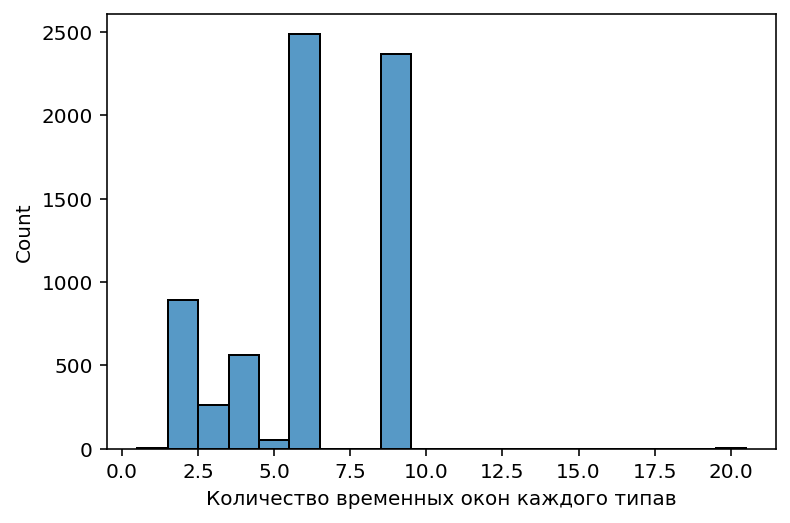

Text(0.5, 0, 'Начало временного окна')

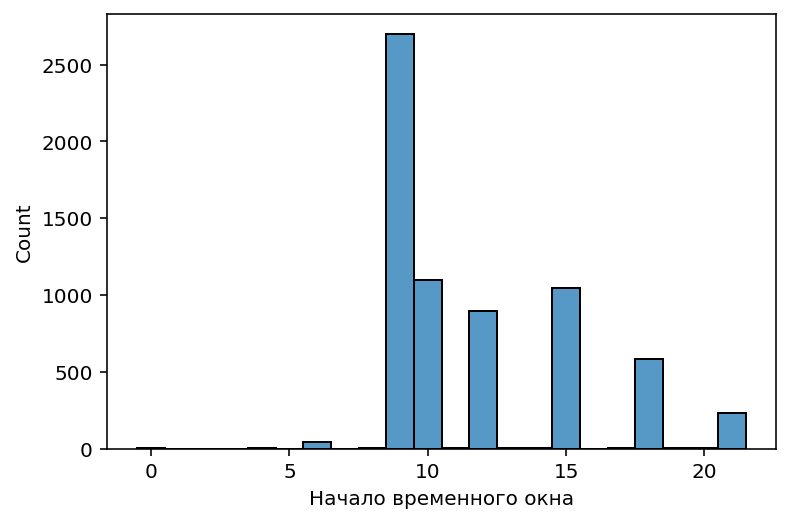

Text(0.5, 0, 'Конец временного окна')

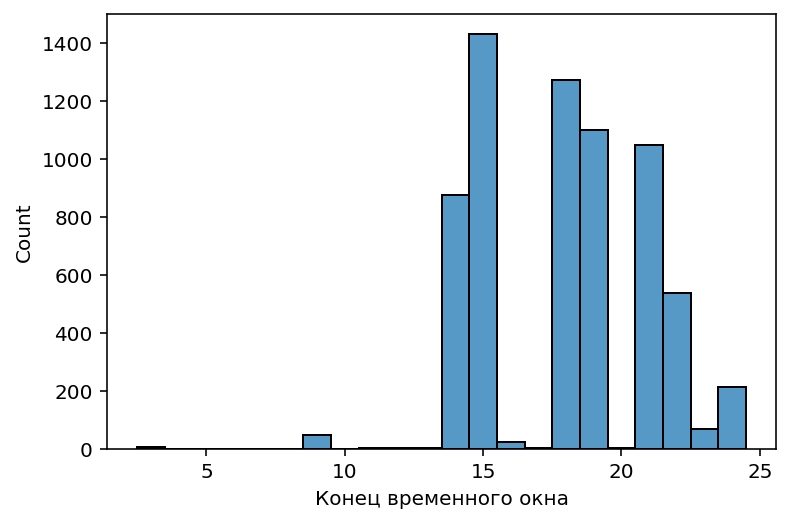

In [233]:
# фиксим отсутствующие
t_to[t_to == ''] = '24'
t_from[t_from == ''] = '00'

# фиксим типы данных
t_to = t_to.astype(int)
t_from = t_from.astype(int)

# фиксим нерабочие окна
t_to[t_to <= t_from] = 24

t_diffs = (t_to - t_from)
# График каждого количества
sns.histplot(t_diffs, bins=range(25), discrete=True)
# t_diffs.value_counts().head(30).plot(kind='barh', figsize=(20,10))
plt.xlabel('Количество временных окон каждого типав')
plt.show()

sns.histplot(t_from, discrete=True)
plt.xlabel('Начало временного окна')
plt.show()


sns.histplot(t_to, discrete=True)
plt.xlabel('Конец временного окна')
plt.show()

In [263]:
data['t_from'] = t_from
data['t_to'] = t_to
data['window_len'] = t_diffs

In [280]:
## Строим matplotlib

(36.0, 39.25)

(55.0, 56.5)

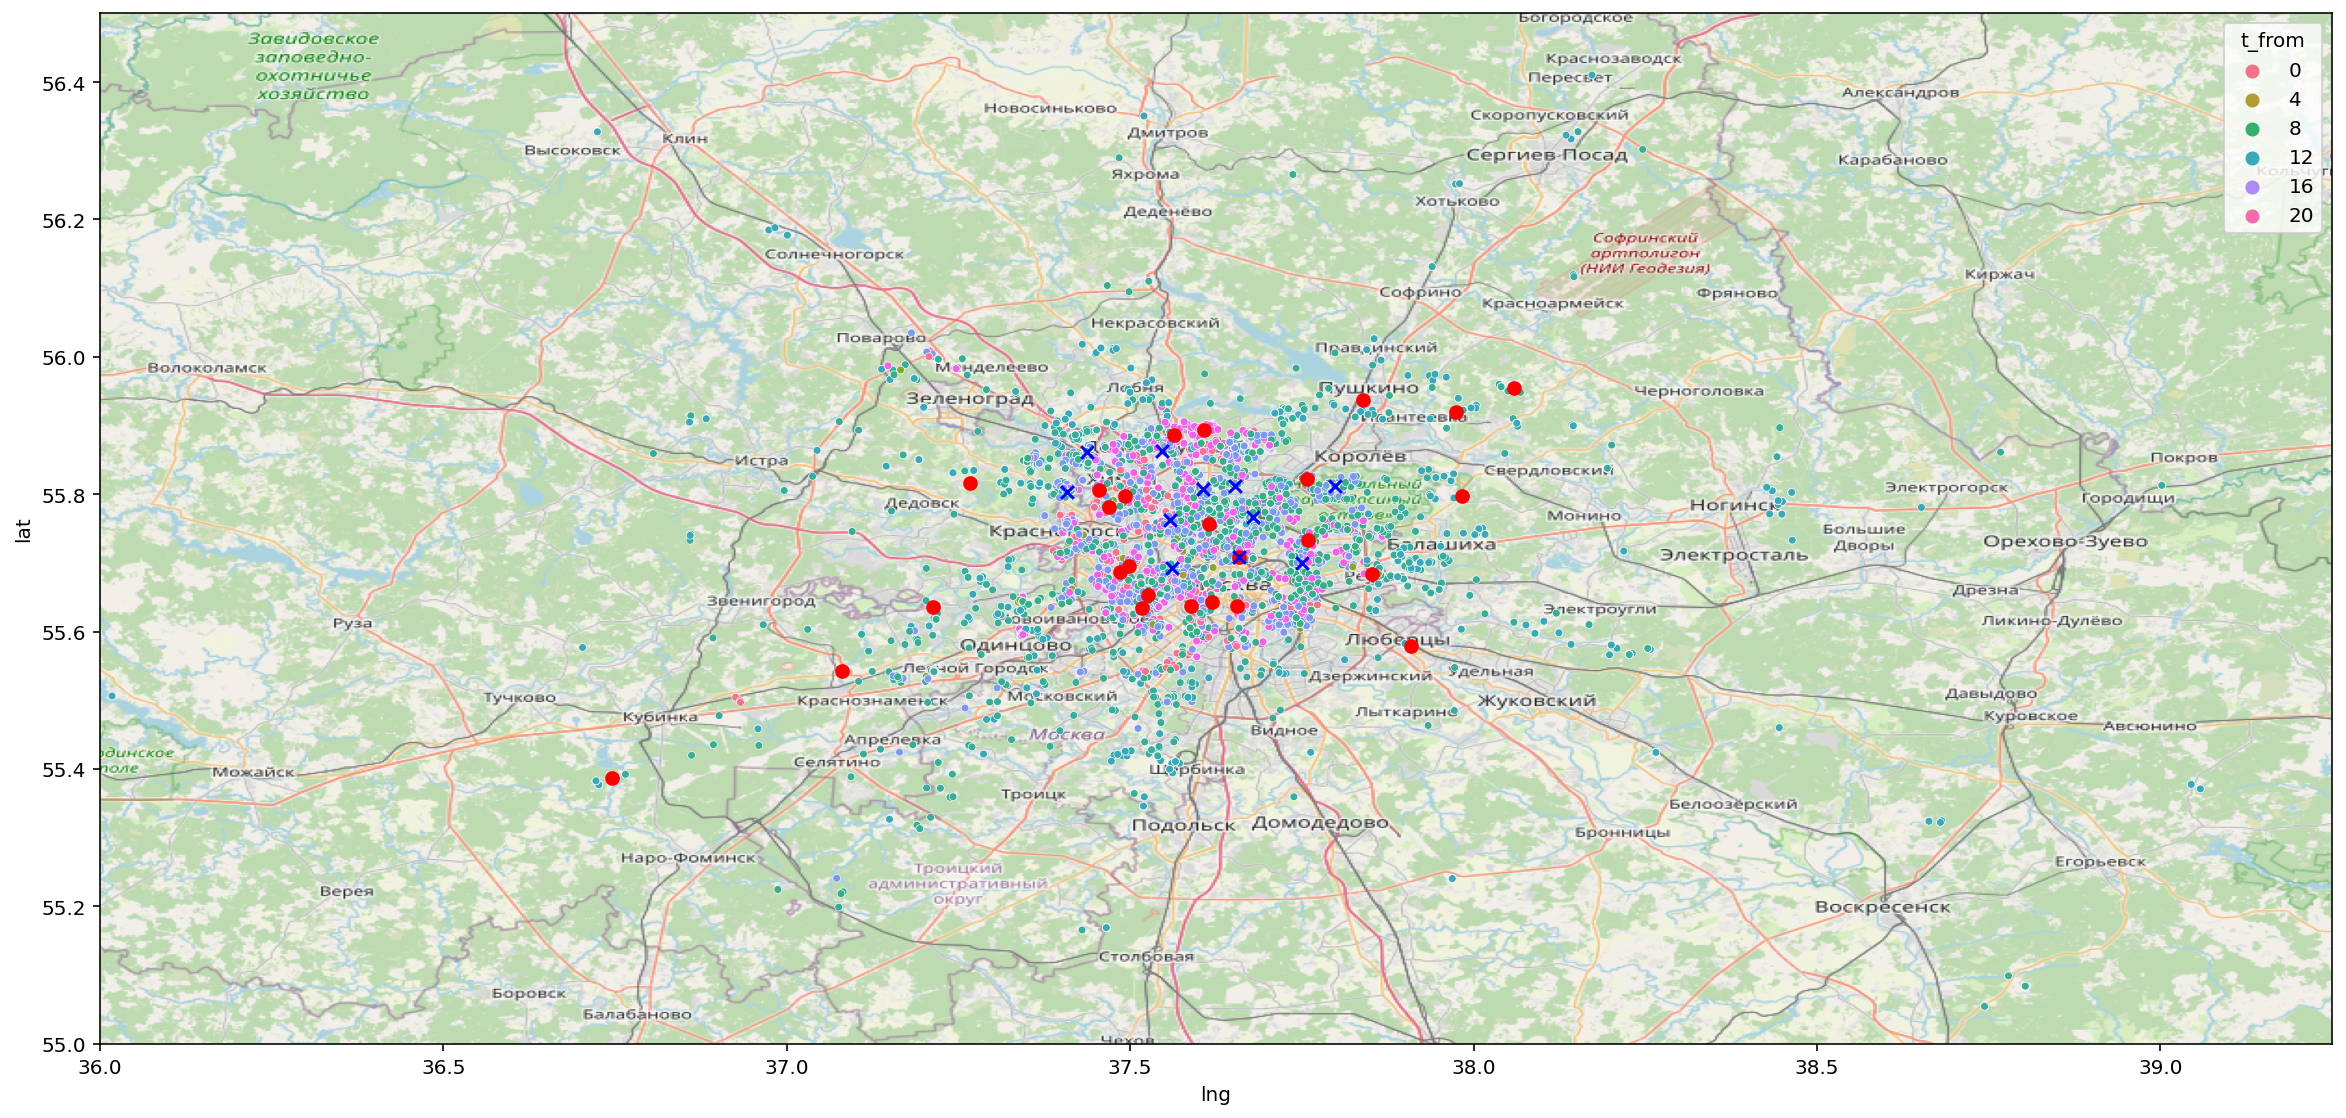

In [281]:
import seaborn as sns
import matplotlib.pyplot as plt

box = (36, 39.25, 55, 56.5)
fig, ax = plt.subplots(figsize=(20, 20))
sns.scatterplot(data=data, x='lng', y='lat', hue='t_from', ax=ax, palette='husl', s=15)
prior=data[~data['Приоритет'].isna()]

plt.scatter(x=prior.lng, y=prior.lat, c='r', s=40)
plt.scatter(y=stocks['Широта'].astype(float), x=stocks['Долгота'].astype('float'), c='b', marker='x', s=40)

plt.xlim(box[0], box[1])
plt.ylim(box[2], box[3])

map_back = plt.imread('../data/map.png')
ax.imshow(map_back, zorder=0, extent=box)

In [ ]:
folium.features.C

In [305]:
## Теперь через follium
import folium
tiles='Stamen Toner'  # черно-белая
tiles = 'Stamen Terrain'  # растительность

mos_map = folium.Map(location=[55.7539, 37.6208], zoom_start=11, tiles=tiles)

unused = folium.map.FeatureGroup()
for t in data.itertuples():
    a = folium.CircleMarker(
        [t.lat, t.lng],
        radius=5,
        color='yellow',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
    ).add_to(unused)

for t in stocks.itertuples():
    a = folium.CircleMarker(
        [t.lat, t.lng],
        radius=5,
        color='yellow',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
    ).add_to(unused)

mos_map.add_child(unused)